In [7]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

#%%
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [2]:
print(len(os.listdir('D:\\dungnd\\data\\CASIA2\\Au')))
print(len(os.listdir('D:\\dungnd\\data\\CASIA2\\Tp')))

7491
5123


In [ ]:
# os.remove('D:\\dungnd\\data\\CASIA2\\Au\\.DS_Store')
# os.remove('D:\\dungnd\\data\\CASIA2\\Pt\\.DS_Store')

In [8]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    os.remove(temp_filename)
    return ela_image
  
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 98).resize([128,128])).flatten() / 255.0

In [9]:
X_train = [] # ELA converted images
X_test = [] # ELA converted images
y_train = [] # 0 for fake, 1 for real 
y_test = [] # 0 for fake, 1 for real 

path = 'D:\\dungnd\\data\\Au_Train' 
j=0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        
        if filename.endswith('jpg') or filename.endswith('bmp'):
            j=j+1
            full_path = os.path.join(dirname, filename)
            X_train.append(prepare_image(full_path))
            y_train.append(1)
            if len(y_train) % 500 == 0:
                print(f'Processing {len(y_train)} images')
                print(j)
                
path = 'D:\\dungnd\\data\\Tp_Train' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X_train.append(prepare_image(full_path))
            y_train.append(0)
            if len(y_train) % 500 == 0:
                print(f'Processing {len(y_train)} images')
                print(j)

path = 'D:\\dungnd\\data\\Au_Test' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1
        if filename.endswith('jpg') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X_test.append(prepare_image(full_path))
            y_test.append(1)
            if len(y_test) % 500 == 0:
                print(f'Processing {len(y_test)} images')
                print(j)
                
path = 'D:\\dungnd\\data\\Tp_Test' 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        j=j+1
        if filename.endswith('jpg') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X_test.append(prepare_image(full_path))
            y_test.append(0)
            if len(y_test) % 500 == 0:
                print(f'Processing {len(y_test)} images')
                print(j)

                
#%%

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(y_train, 2)

y_test = to_categorical(y_test, 2)
X_train = X_train.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 128, 128, 3)
#%%

#X_train, X_val, y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
#X = X.reshape(-1,1,1,1)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

Processing 500 images
500
Processing 1000 images
1000
Processing 1500 images
1500
Processing 2000 images
2000
Processing 2500 images
2500
Processing 3000 images
3000
Processing 3500 images
3500
Processing 4000 images
4000
Processing 4500 images
4500
Processing 5000 images
5000
Processing 5500 images
5500
Processing 6000 images
6000
Processing 6500 images
6500
Processing 7000 images
7000
Processing 7500 images
7500
Processing 8000 images
8000
Processing 8500 images
8500
Processing 9000 images
9000
Processing 9500 images
9500
Processing 10000 images
10000
Processing 500 images
10591
Processing 1000 images
11091
Processing 1500 images
11591
Processing 2000 images
12091
Processing 2500 images
12591
10091 10091
2523 2523


In [7]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation = 'relu'))
   
    model.add(Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2, 2)))
   
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))

    model.summary()
    return model

In [11]:
model = build_model()
model.summary()
epochs = 100
batch_size = 64
init_lr = 1e-5
optimizer = Adam(learning_rate = init_lr)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("model_best_98.h5", monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 300, verbose = 0, mode = 'auto')

#%%
hist = model.fit(X_train, 
                 y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_test, y_test),
                 callbacks = [checkpoint, early_stopping])

#%%
model.save('model_casia_best.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 32)      50208     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 59, 59, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 111392)            0         
                                                      

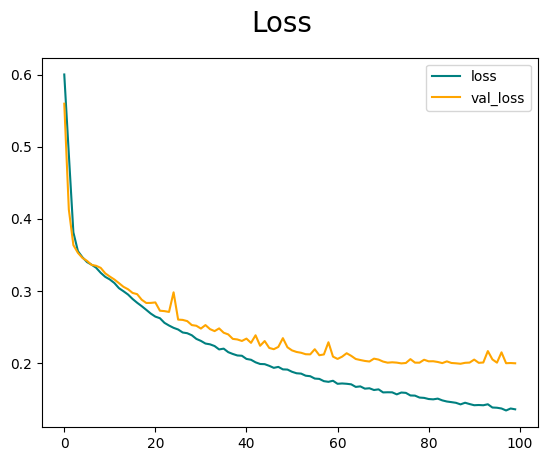

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

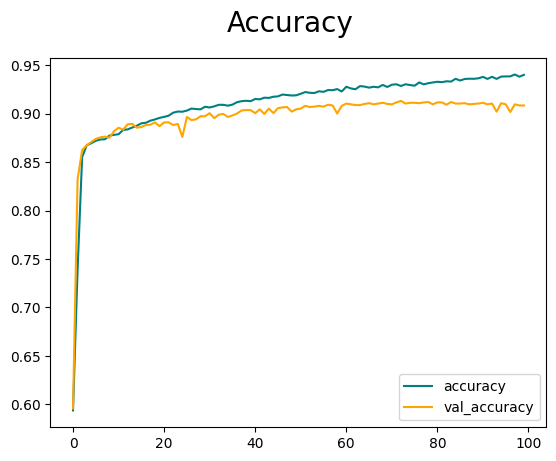

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

79/79 [==============================] - 24s 296ms/step
Confusion Matrix:
[[ 970   55]
 [ 176 1322]]
Precision: 0.9600580973129993
Recall: 0.8825100133511349
Accuracy: 0.9084423305588585


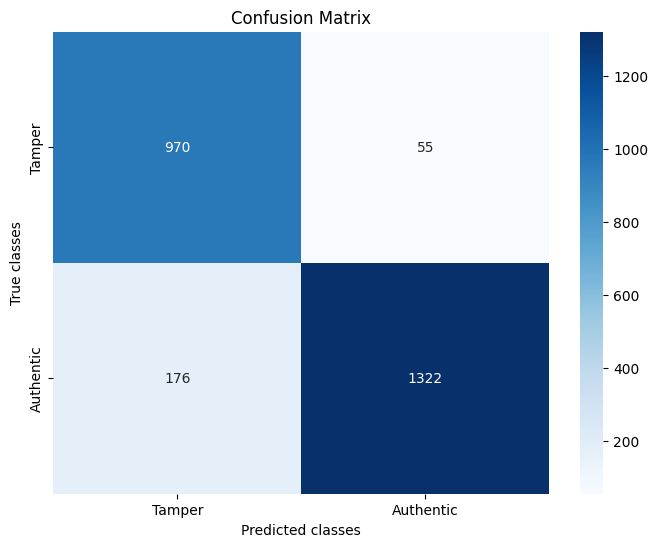

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
saved_model = load_model("D:\\dungnd\\GraduationProject\\checkpoint\\casia2_checkpoint\\model_casia_best.h5")

# Make predictions on the test data
y_pred = saved_model.predict(X_test)
# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate Precision, Recall, and Accuracy
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Tamper", "Authentic"], yticklabels=["Tamper", "Authentic"])
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix')
plt.show()

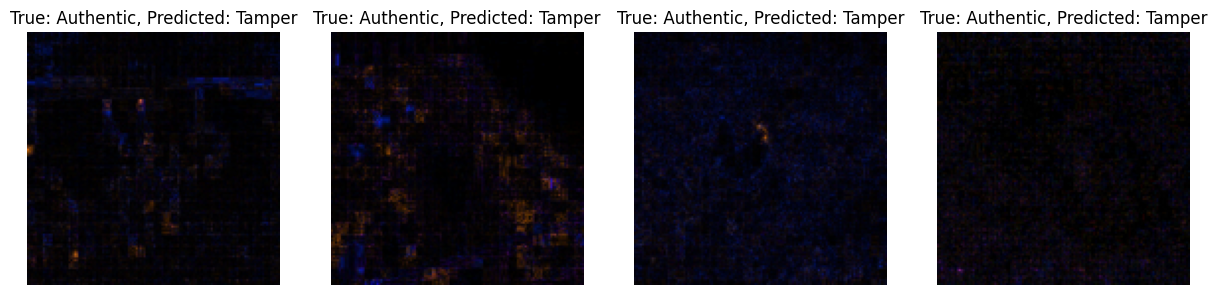

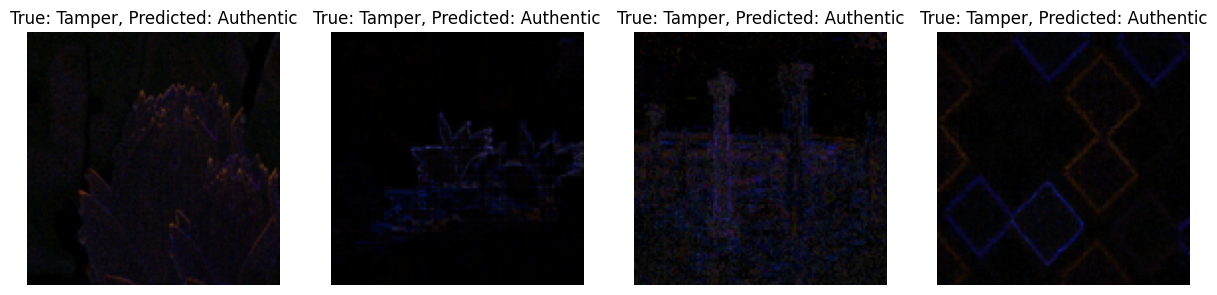

In [12]:
# Find indices where predictions are incorrect
errors = np.where(y_pred_classes != y_true_classes)[0]
labels = ['Tamper', 'Authentic']
# Display the first 5 wrong predictions
# Display images corresponding to the first 5 wrong predictions
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for i, idx in enumerate(errors[:4]):
    img = X_test[idx]
    true_label = labels[y_true_classes[idx]]
    pred_label = labels[y_pred_classes[idx]]
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}, Predicted: {pred_label}")
    axes[i].axis('off')
plt.show()

# Display the last 5 wrong predictions
# Display images corresponding to the last 5 wrong predictions
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for i, idx in enumerate(errors[-4:]):
    img = X_test[idx]
    true_label = labels[y_true_classes[idx]]
    pred_label = labels[y_pred_classes[idx]]
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}, Predicted: {pred_label}")
    axes[i].axis('off')
plt.show()

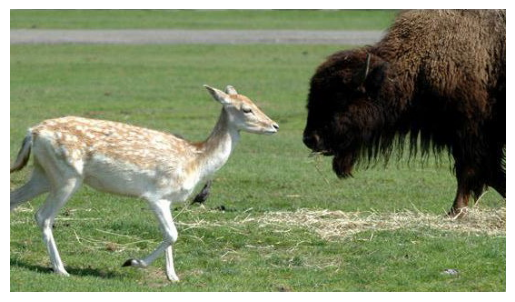

tf.Tensor([[0.31338292 0.68661714]], shape=(1, 2), dtype=float32)
tf.Tensor(0.31338292, shape=(), dtype=float32)
tf.Tensor(0.68661714, shape=(), dtype=float32)
authentic image
1/1 [==============================] - 0s 169ms/step
[[0.31338292 0.68661714]]


In [4]:
from tensorflow.keras.models import load_model
import cv2
saved_model = load_model("D:\\dungnd\\GraduationProject\\checkpoint\\casia2_checkpoint\\model_casia_best.h5")

img = cv2.imread("D:\\dungnd\\data\\Au_Test\\Au_Test\\Au_ani_10161.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.imshow(img)
plt.axis('off')
plt.show()

X = prepare_image(image_path= "D:\\dungnd\\data\\Au_Test\\Au_Test\\Au_ani_10161.jpg")
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
A = saved_model(X)
print(A)
print(A[0][0])
print(A[0][1])
if A[0][1] < A[0][0]:
    print("tamper image")
else: print("authentic image")
print(saved_model.predict(X))

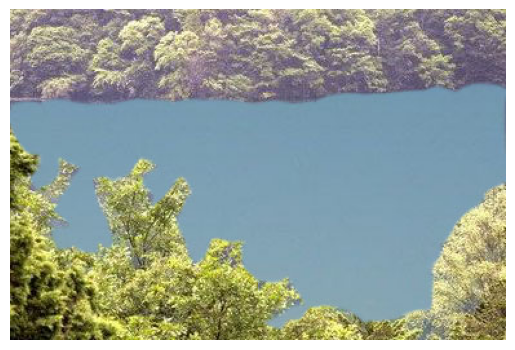

tf.Tensor([[9.9994886e-01 5.1191757e-05]], shape=(1, 2), dtype=float32)
tf.Tensor(0.99994886, shape=(), dtype=float32)
tf.Tensor(5.1191757e-05, shape=(), dtype=float32)
tamper image
1/1 [==============================] - 0s 96ms/step
[[9.9994886e-01 5.1191757e-05]]


In [5]:
img = cv2.imread("D:\\dungnd\\data\\Tp_Test\\Tp_Test\\Tp_D_CNN_M_N_nat00089_nat00062_10577.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.imshow(img)
plt.axis('off')
plt.show()

X = prepare_image(image_path= "D:\\dungnd\\data\\Tp_Test\\Tp_Test\\Tp_D_CNN_M_N_nat00089_nat00062_10577.jpg")
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
A = saved_model(X)
print(A)
print(A[0][0])
print(A[0][1])
if A[0][1] < A[0][0]:
    print("tamper image")
else: print("authentic image")
print(saved_model.predict(X))

In [ ]:
import pickle

# save history:
f = open('casia2_history.pckl', 'wb')
pickle.dump(hist.history, f)
f.close()

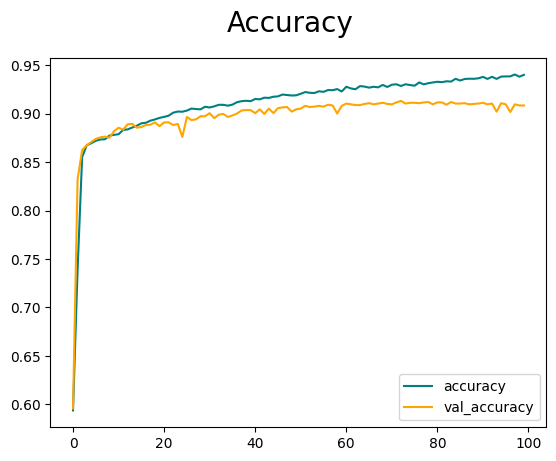

In [ ]:
# retrieve history:    
f = open('casia2_history.pckl', 'rb')
history = pickle.load(f)
f.close()


fig = plt.figure()
plt.plot(history['accuracy'], color='teal', label='accuracy')
plt.plot(history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

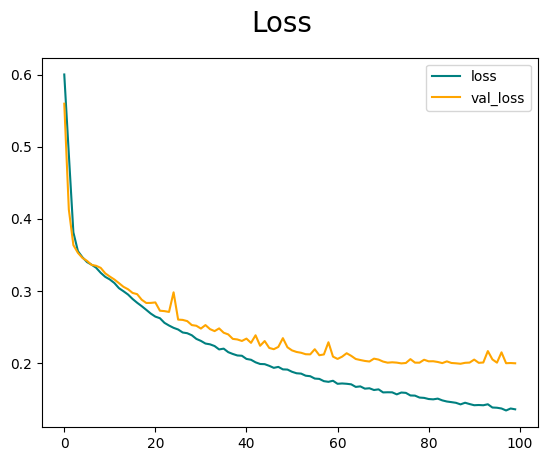

In [ ]:
fig = plt.figure()
plt.plot(history['loss'], color='teal', label='loss')
plt.plot(history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

In [4]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity
import cv2

def find_mask(tp_path):
    au_index = [3, 6, 7, 12]  # indices of authetic image name
    background_index = [13, 21]  # indices of background image in the tamoered image name

    au_pic_list = glob(r'D:\dungnd\data\CASIA2\Au\*')
    au_pic_dict = {
        os.path.basename(au_pic)[au_index[0]:au_index[1]] + os.path.basename(au_pic)[au_index[2]:au_index[3]]:
            au_pic for au_pic
        in au_pic_list}
    
    tp_name = tp_path.split(os.sep)[-1][background_index[0]:background_index[1]]
    if tp_name in au_pic_dict.keys():
        au_pic = au_pic_dict[tp_name]
        au_image = plt.imread(au_pic)
        tp_image = plt.imread(tp_path)
        print("Auth image path: ", au_pic)
        print("Tamper image path: ", tp_path)
        if tp_image.shape == au_image.shape:
            # convert images to grayscale
            gray_au_image = cv2.cvtColor(au_image, cv2.COLOR_BGR2GRAY)
            gray_sp_image = cv2.cvtColor(tp_image, cv2.COLOR_BGR2GRAY)
            # get the difference of the 2 grayscale images
            (_, diff) = structural_similarity(gray_au_image, gray_sp_image, full=True)
            diff = cv2.medianBlur(diff, 1)
            # make background black and tampered area white
            mask = np.ones_like(diff)
            mask[diff < 0.98] = 1
            mask[diff >= 0.98] = 0
            mask = (mask * 255).astype("uint8")
            cv2.imwrite(r'D:\dungnd\GraduationProject\masks\casia2\mask_ground_truth.png', mask)

            # Display images
            plt.figure(figsize=(10, 6))

            plt.subplot(1, 3, 1)
            plt.imshow(au_image)
            plt.title('Authentic Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(tp_image)
            plt.title('Tampered Image')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(mask, cmap='gray')
            plt.title('Ground Truth (Mask)')
            plt.axis('off')

            plt.show()

In [52]:
from tensorflow.keras.models import load_model
saved_model = load_model("D:\\dungnd\\GraduationProject\\checkpoint\\casia2_checkpoint\\model_casia_best.h5")

Tamper image
Auth image path:  D:\dungnd\data\CASIA2\Au\Au_pla_00004.jpg
Tamper image path:  D:\dungnd\data\Tp_Test\Tp_Test\Tp_S_NRN_S_B_pla00004_pla00004_00544.tif


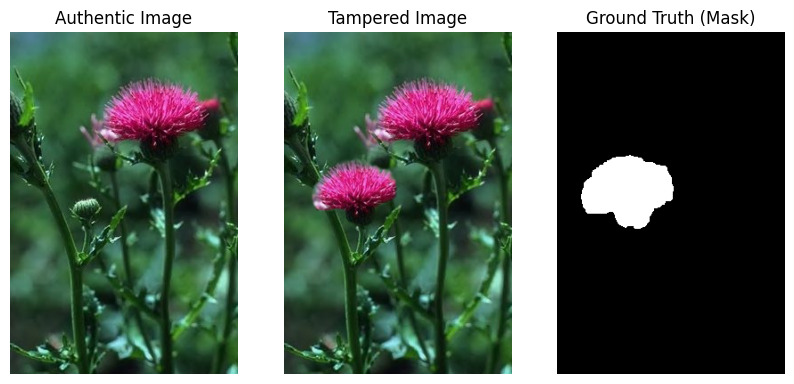

1/1 [==============================] - 0s 261ms/step
[[9.993319e-01 6.680902e-04]]


In [61]:
image_path="D:\\dungnd\\data\\Tp_Test\\Tp_Test\\Tp_S_NRN_S_B_pla00004_pla00004_00544.tif"

X = prepare_image(image_path=image_path)
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
A = saved_model(X)
if A[0][1] < A[0][0]:
    print("Tamper image")
    find_mask(image_path)
else: print("Authentic image")
print(saved_model.predict(X))